# Overall performance of module detection methods

In [1]:
import sys
import os
sys.path.insert(0,os.path.abspath("../lib/"))

import json

from util import JSONExtendedEncoder

from modulecontainers import Modules

%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib.pyplot import *

import pandas as pd
import numpy as np

import multiprocessing as mp

from collections import OrderedDict

from itertools import product
from collections import defaultdict

import itertools
import shutil

conf_folder = "conf/"
base_folder = "~/tmp/"

import os

from modulescomparison_baselines import ModevalKnownmodules, ModevalCoverage

# Running a method on different parameter settings and datasets

The following code will explore the parameters of a module detection method on every dataset using a grid-search approach.

If you want to run your own method, you should wrap it into a python function and add its parameters to `paramexplo_blueprints.py`. We will show the whole workflow here for a "dummy"  (but fast) clustering method, which will simply group genes randomly.

Every module detection method is wrapped in a python function (see lib/moduledetection.py)

Because module detection methods usually take a while to run, we generate the files necessary to run a method on the several parameter settings and datasets here. These can then be easily called from the commandline, for example on a computer cluster or locally using GNU `parallel`.

This function will be called by scripts/moduledetection.py , which will save the modules in the correct format along with additional run information (such as running times).

In [2]:
# datasets to run
datasetnames = ["ecoli_colombos", "ecoli_dream5", "yeast_gpl2529", "yeast_dream5", "synth_ecoli_regulondb", "synth_yeast_macisaac", "human_tcga", "human_gtex", "human_seek_gpl5175"]

# paramexplo_blueprints.py stores for every method the parameters which will be varied using a grid-search approach.
%run ../conf/paramexplo_blueprints.py

# choose the method to evaluate
method_name = "baseline_scalefree"
methodblueprint = blueprints[method_name]

/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/nbs/moduledetection-evaluation/conf/paramexplo_blueprints.py:216: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "qvalcutoff":10**(-np.arange(1, 15, dtype=np.float))
/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/nbs/moduledetection-evaluation/conf/paramexplo_blueprints.py:226: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20;

Generate different parameter settings using a grid-search.

In [3]:
params_folder = "conf/paramexplo/" + method_name + "/"
if os.path.exists("../" + params_folder):
    shutil.rmtree("../" + params_folder)
os.makedirs("../" + params_folder)

methodsettings = []
method_locations = []
i = 0
for dynparam_combination in list(itertools.product(*[methodblueprint["dynparams"][param] for param in sorted(methodblueprint["dynparams"].keys())])):
    method = {"params":{}}
    method["params"] = methodblueprint["staticparams"].copy()
    method["params"].update(dict(zip(sorted(methodblueprint["dynparams"].keys()), dynparam_combination)))
    method["location"] = params_folder + str(i) + ".json"
    method["seed"] = 0

    methodsettings.append(method)

    json.dump(method, open("../" + method["location"], "w"), cls=JSONExtendedEncoder)

    method_locations.append(method["location"])

    i+=1

Now combine the different parameter settings and datasets. Then generate the different python commands to run every parameter setting and dataset in parallel.

In [4]:
settings_name = "paramexplo/{method_name}".format(method_name = method_name)
settings = [{
        "dataset_location":"conf/datasets/" + datasetname + ".json",
        "dataset_name":datasetname,
        "method_location":methodsetting["location"],
        "output_folder":"results/" + methodblueprint["type"] + "/{settings_name}/{i}/".format(settings_name=settings_name, i=i),
        "settingid":i
    } for i, (datasetname, methodsetting) in enumerate(product(datasetnames, methodsettings))]
json.dump(settings, open("../conf/settings/{settings_name}.json".format(settings_name=settings_name), "w"))

In [5]:
settings_dataset = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["dataset_location"]))["params"]) for setting in settings])
settings_method = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["method_location"]))["params"]) for setting in settings])

In [6]:
commands = ""
for i, setting in enumerate(settings):
    #commands += "python scripts/moduledetection.py {method_location} {dataset_location} {output_folder} 0 test\n".format(**setting)
    commands += "python3 scripts/" + methodblueprint["type"] + ".py {method_location} {dataset_location} {output_folder}\n".format(**setting)

commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs("../" + os.path.dirname(commands_location), exist_ok=True)
with open("../" + commands_location, "w") as outfile:
    outfile.write(commands)
commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs(os.path.dirname(base_folder + commands_location), exist_ok=True)
with open(base_folder + commands_location, "w") as outfile:
    outfile.write(commands)
    
#script_location = generate_batchcode(commands_location, settings_name, len(settings), {"memory":"10G", "numcores":1}, "biclust_comp2")

# this command can be used on most linux computers to run the different parameter settings in parallel
print("parallel -a " + commands_location)

parallel -a tmp/paramexplo/baseline_scalefree.txt


# Evaluating the method

## By comparing with known modules

In [7]:
# create pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(mp.cpu_count()-1)

In [8]:
# settings_filtered = [setting for setting in settings if not setting["dataset_name"].startswith("human")] # only evaluate non-human datasets
# display(settings_filtered)

In [9]:
settings_filtered = [setting for setting in settings if not setting["dataset_name"].startswith("human")] # only evaluate non-human datasets
modeval = ModevalKnownmodules(settings_filtered)
modeval.run(pool)

In [10]:
modeval.save(settings_name)

## Using the coverage of regulators

In [11]:
from modulescomparison_baselines import ModevalCoverage

In [12]:
# built a pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(mp.cpu_count()-1)

/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/nbs/moduledetection-evaluation/lib/modulescomparison_baselines.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _,qvalrow,_,_ = np.array(multipletests(pvalrow))
/home/miltondp/software/miniconda3/envs/clustermatch_gene_expr/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/nbs/moduledetection-evaluation/lib/modulescomparison_baselines.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengt

/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/nbs/moduledetection-evaluation/lib/modulescomparison_baselines.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _,qvalrow,_,_ = np.array(multipletests(pvalrow))
/home/miltondp/software/miniconda3/envs/clustermatch_gene_expr/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/nbs/moduledetection-evaluation/lib/modulescomparison_baselines.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengt

/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/nbs/moduledetection-evaluation/lib/modulescomparison_baselines.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _,qvalrow,_,_ = np.array(multipletests(pvalrow))
/home/miltondp/software/miniconda3/envs/clustermatch_gene_expr/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/nbs/moduledetection-evaluation/lib/modulescomparison_baselines.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengt

In [13]:
settings_filtered = [setting for setting in settings if setting["dataset_name"].startswith("human")] # only evaluate human datasets
modeval = ModevalCoverage(settings_filtered)
modeval.run(pool)

Evaluating a total of 3 settings.


In [14]:
modeval.save(settings_name)

In [15]:
modeval.load(settings_name)

## Comparing with other methods

In [16]:
def score_method(scores):
    methodscores = []
    for ((datasetoi, goldstandardoi), scoresoi), ((datasetor, goldstandardor), scoresor) in product(scores.groupby(["datasetname", "goldstandard"]), scores.groupby(["datasetname", "goldstandard"])):
        if (datasetor.split("_")[0]=="synth" and datasetoi.split("_")[0]!="synth") or (datasetor.split("_")[0]!="synth" and datasetoi.split("_")[0]=="synth"):
            continue
                
        if (goldstandardoi.split("#")[-1] != goldstandardor.split("#")[-1]):
            if (datasetoi.startswith("human") != datasetor.startswith("human")):
                ""
            else:
                continue

        # find the most optimal method parameters in the reference dataset (test dataset)
        bestparams = scoresor[paramsoi].loc[scoresor["score"].idxmax()]
        
        try:
            rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
        except:
            print(scoresoi)

        # now find these parameters in the dataset of interest (training dataset)
        rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
            
        if len(rowids) == 0:
            print("parameters could not be matched!!", datasetoi, datasetor)
            print(bestparams)
            print([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()])
        if len(rowids) > 1:
            print(datasetoi)
            print("multiple matched parameters")
            print(scoresoi.loc[rowids][paramsoi])

        methodscores.append({
            "datasetoi":datasetoi,
            "datasetor":datasetor,
            "score":scoresoi.loc[rowids,"score"].max(),
            "method":methodname,
            "goldstandardoi":goldstandardoi,
            "goldstandardor":goldstandardor,
            "ofinterest":datasetoi + "#" + goldstandardoi,
            "ofreference":datasetor + "#" + goldstandardor,
            "runningtime":scoresoi.loc[rowids, "runningtime"].mean() if "runningtime" in scoresoi.columns else 0,
            "moduledef":scoresoi.loc[rowids, "moduledef"].tolist()[0],
            "organismoi":scoresoi.loc[rowids, "organism"].tolist()[0],  
        })
    
    return pd.DataFrame(methodscores)

In [17]:
methodnames = [method_name]

In [18]:
finalscores = []
for methodname in methodnames:
    settings_name = "paramexplo/" + methodname
    settings = json.load(open("../conf/settings/{}.json".format(settings_name)))
    settings_dataset = pd.DataFrame([dict(settingid=settingid, **json.load(open("../" + setting["dataset_location"]))["params"]) for settingid, setting in enumerate(settings)])
    settings_method = pd.DataFrame([dict(settingid=settingid, **json.load(open("../" + setting["method_location"]))["params"]) for settingid, setting in enumerate(settings)])
    
    print(methodname)
    paramsoi = methodparamsoi[methodname]

    scores = pd.DataFrame()
    
    modeval = ModevalKnownmodules(settings_name)
    modeval.load(settings_name)
    modeval.scores["score"] = modeval.scores["F1rprr"]
    modeval.scores["moduledef"] = [modulesname if modulesname in ["minimal", "strict"] else "interconnected" for modulesname in modeval.scores["knownmodules_name"]]
    modeval.scores = modeval.scores.merge(settings_dataset, on="settingid").merge(settings_method, on="settingid")
    scores = scores.append(modeval.scores, ignore_index=True)
    
    modeval = ModevalCoverage(settings_name)
    modeval.load(settings_name)
    modeval.scores["score"] = modeval.scores["aucodds"]
    modeval.scores = modeval.scores.merge(settings_dataset, on="settingid").merge(settings_method, on="settingid")
    scores = scores.append(modeval.scores, ignore_index=True)
    
    methodscores = score_method(scores)
    
    methodscores["organismnetoi"] = [dataset.split("_")[0] for dataset in methodscores["goldstandardoi"]]
    methodscores["organismnetor"] = [dataset.split("_")[0] for dataset in methodscores["goldstandardor"]]

    finalscores.append(methodscores)
finalscores = pd.concat(finalscores, ignore_index=True)

baseline_scalefree


In [19]:
def add_weights(scores):
    weights = []
    scores["moduledef"] = scores["moduledef"].fillna("")
    for organismoi, subscores in scores.groupby("organismoi"):
        moduledef_weights = 1/subscores.groupby("moduledef")["score"].count()
        for moduledef, weight in moduledef_weights.items():
            weights.append({
                    "organism":organismoi,
                    "moduledef":moduledef,
                    "weight":weight / len(moduledef_weights)
                })
    weights = pd.DataFrame(weights).set_index(["organism", "moduledef"])["weight"]
    
    scores["weight"] = weights.loc[pd.Index(scores[["organismoi", "moduledef"]])].tolist()
    
    return scores

In [20]:
trainingscores_ = add_weights(finalscores.loc[(finalscores["ofinterest"] == finalscores["ofreference"])])
testscores_ = add_weights(finalscores.loc[(finalscores["ofinterest"] != finalscores["ofreference"]) & (finalscores["organismnetoi"] != finalscores["organismnetor"])])

trainingscores = trainingscores_.groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))
testscores = testscores_.groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))

/tmp/ipykernel_144410/4089861130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["moduledef"] = scores["moduledef"].fillna("")
/tmp/ipykernel_144410/4089861130.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["weight"] = weights.loc[pd.Index(scores[["organismoi", "moduledef"]])].tolist()


In [21]:
testscores_.to_csv("../results/testscores_.tsv", sep="\t")
trainingscores_.to_csv("../results/trainingscores_.tsv", sep="\t")

In [22]:
trainingscores

method
baseline_scalefree    0.008901
dtype: float64

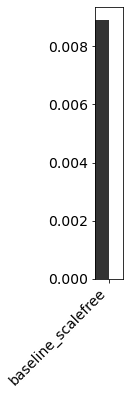

In [23]:
fig, ax = subplots(figsize=(len(trainingscores)/2, 5))

methodorder = testscores.sort_values(ascending=False).index

ax.bar(range(len(methodorder)), trainingscores[methodorder], color="grey")
ax.bar(range(len(methodorder)), testscores[methodorder], color="#333333")
ax.set_xlim(-0.2, len(methodorder))
ax.set_xticks(np.arange(len(methodorder))+0.4)
ax.set_xticklabels(methodorder, rotation=45, ha="right", va="top")
""


ax.tick_params(labelsize=14)